In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg, lil_matrix

In [139]:
h = 0.01
h0 = 0.05
M = 30
k0 = 50
R = 0.5
center = [0, 0]
x_l, x_r = -1, 1
y_l, y_r = -1, 1
k1 = 10
k2 = 10
lx, ly = np.abs(x_r - x_l), np.abs(y_r - y_l)
Nx, Ny = int(np.round(lx / h)), int(np.round(ly / h))
hx, hy = lx / Nx, ly / Ny

x = np.linspace(x_l + hx / 2, x_r - hx / 2, Nx)
y = np.linspace(y_l + hy / 2, y_r - hy / 2, Ny)

X, Y = np.meshgrid(x, y, indexing="ij")

In [140]:
def f(x, y):
    r = np.sqrt(x ** 2 + y ** 2)
    return (M / (2 * np.pi * R * h0)) * np.exp(-((r - R) / h0) ** 2)

def phi_l(k1, k2):
    return k1 * np.sin(2 * k1)

def phi_r(k1, k2):
    return k1 * np.sin(2 * k1)

def phi_b(k1, k2):
    return -k2 * np.sin(2 * k2)

def phi_t(k1, k2):
    return -k2 * np.sin(2 * k2)

In [141]:
def RHS(X, Y, k1, k2, hx, hy):
    res = f(X, Y)
    res[0, :] += phi_l(k1, k2) / hx
    res[-1, :] += phi_r(k1, k2) / hx
    res[:, 0] += phi_b(k1, k2) / hy
    res[:, -1] += phi_t(k1, k2) / hy
    return res

In [142]:
def getL(Nx, Ny, hx, hy):
    k = np.arange(Nx * Ny, dtype=int).reshape((Nx, Ny))
    L = lil_matrix((Nx * Ny, Nx * Ny))
    
    for i in range(Nx):
        for j in range(Ny):
            L[k[i, j], k[i, j]] += k0 / (hx * hy)
            
            if i == 0:
                L[k[i, j], k[i, j]] += 1 / (hx ** 2)
                L[k[i, j], k[i + 1, j]] -= 1 / (hx ** 2)
            elif i == Nx - 1:
                L[k[i, j], k[i, j]] += 1 / (hx ** 2)
                L[k[i, j], k[i - 1, j]] -= 1 / (hx ** 2)
            else:
                L[k[i, j], k[i - 1, j]] -= 1 / (hx ** 2)
                L[k[i, j], k[i + 1, j]] -= 1 / (hx ** 2)
                L[k[i, j], k[i, j]] += 2 / (hx ** 2)
            
            if j == 0:
                L[k[i, j], k[i, j]] += 1 / (hy ** 2)
                L[k[i, j], k[i, j + 1]] -= 1 / (hy ** 2)
            elif j == Ny - 1:
                L[k[i, j], k[i, j]] += 1 / (hy ** 2)
                L[k[i, j], k[i, j - 1]] -= 1 / (hy ** 2)
            else:
                L[k[i, j], k[i, j - 1]] -= 1 / (hy ** 2)
                L[k[i, j], k[i, j + 1]] -= 1 / (hy ** 2)
                L[k[i, j], k[i, j]] += 2 / (hy ** 2)
    
    return L.tocsr()

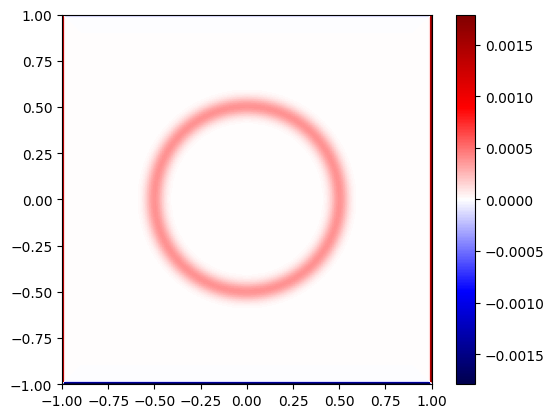

In [143]:
L = getL(Nx, Ny, hx, hy)
F = RHS(X, Y, k1, k2, hx, hy).flatten()
u = linalg.spsolve(L, F).reshape((Nx, Ny))
plt.imshow(u.T, extent=(x_l, x_r, y_l, y_r), cmap='seismic')
plt.colorbar()